In [18]:
import pandas as pd
import networkx as nx
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
import numpy as np
from scipy.cluster.hierarchy import linkage, dendrogram
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
import seaborn as sns
import os
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from prefixspan import PrefixSpan
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.decomposition import TruncatedSVD
import umap.umap_ as umap

In [2]:
NUMBER_OF_FILES = 30
PATH="data/sessions_full.parquet"

## Read data and some exploration

In [3]:
# read the parquet file
sessions = pd.read_parquet(PATH)

In [4]:
# actions value counts
actions = sessions['action'].value_counts(normalize=True) * 100
actions

simple_search               30.789814
next_page                   21.785991
document_access             21.439175
prev_page                    6.571709
filtering_search_results     4.605041
chosen_page                  3.090379
first_page                   2.335862
zoom                         2.111513
document_download            1.975234
page_download                1.441500
blog_navigation              0.916057
to_single_page_mode          0.840829
homepage                     0.642561
revisit_document             0.552547
heading_navigation           0.458309
to_multi_page_mode           0.187050
advanced_search              0.167612
to_vertical_page_mode        0.040605
to_double_page_mode          0.031658
to_audio_page_mode           0.016554
Name: action, dtype: float64

In [5]:
sessions

,session_id,action,timestamp,Ark
0,S_32_1_U_1006f69309f1ed47ab335755df5ea9bc,simple_search,2016-02-08 18:20:58+01:00,<NA>
1,S_32_1_U_1006f69309f1ed47ab335755df5ea9bc,simple_search,2016-02-08 18:21:00+01:00,<NA>
2,S_32_1_U_1006f69309f1ed47ab335755df5ea9bc,heading_navigation,2016-02-08 18:21:06+01:00,<NA>
3,S_32_1_U_1006f69309f1ed47ab335755df5ea9bc,document_access,2016-02-08 18:21:47+01:00,cb34427363f
4,S_32_1_U_1006f69309f1ed47ab335755df5ea9bc,document_access,2016-02-08 18:21:52+01:00,cb34427363f
...,...,...,...,...
239844,S_109_1_U_ffef2c43f3931c4077afe85a993decce,to_multi_page_mode,2016-02-28 19:57:48+01:00,btv1b85287638
239845,S_109_1_U_ffef2c43f3931c4077afe85a993decce,to_single_page_mode,2016-02-28 19:57:58+01:00,btv1b85287638
239846,S_109_1_U_ffef2c43f3931c4077afe85a993decce,document_access,2016-02-28 19:58:04+01:00,btv1b85287638
239847,S_109_1_U_ffef2c43f3931c4077afe85a993decce,to_single_page_mode,2016-02-28 19:58:35+01:00,btv1b85287638


In [6]:
actions_map = {
    'homepage': 'homepage',
    'blog_navigation': 'blog',
    'heading_navigation': 'heading',
    'simple_search': 'search',
    'advanced_search': 'advanced_search',
    'filtering_search_results': 'filtering_search_results',
    'document_access': 'document',
    'prev_page': 'pagination',
    'next_page': 'pagination',
    'first_page': 'pagination',
    'chosen_page': 'pagination',
    'revisit_document': 'revisit_document',
    'zoom': 'engagement',
    'to_single_page_mode': 'engagement',
    'to_double_page_mode': 'engagement',
    'to_vertical_page_mode': 'engagement',
    'to_audio_page_mode': 'engagement',
    'to_multi_page_mode': 'engagement',
    'page_download': 'download',
    'document_download': 'download'}

In [7]:
# rename action column to action_detailed
sessions.rename(columns={'action': 'action_detailed'}, inplace=True)
# map actions to parent actions
sessions['action'] = sessions['action_detailed'].map(actions_map)

In [8]:
# parent actions value counts
actions_general = sessions['action'].value_counts(normalize=True) * 100
actions_general

pagination                  33.783941
search                      30.789814
document                    21.439175
filtering_search_results     4.605041
download                     3.416734
engagement                   3.228209
blog                         0.916057
homepage                     0.642561
revisit_document             0.552547
heading                      0.458309
advanced_search              0.167612
Name: action, dtype: float64

count    622958.000000
mean         67.297461
std         322.950102
min           1.000000
0%            1.000000
5%            4.000000
10%           5.000000
15%           6.000000
20%           8.000000
25%           9.000000
30%          11.000000
35%          13.000000
40%          16.000000
45%          19.000000
50%          22.000000
55%          27.000000
60%          32.000000
65%          39.000000
70%          48.000000
75%          60.000000
80%          77.000000
85%         102.000000
90%         144.000000
95%         230.000000
max       37415.000000
Name: actions_per_session, dtype: float64


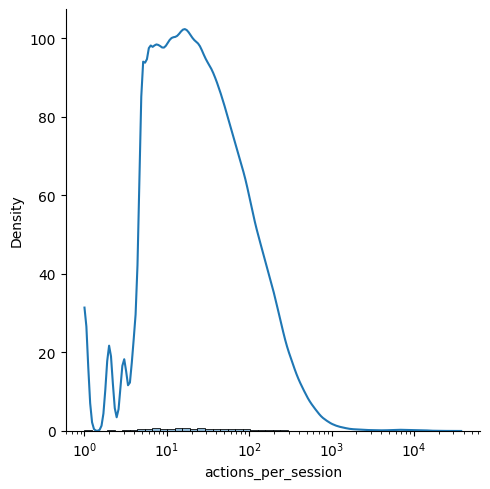

In [9]:
# Calculate the number of actions per session
actions_per_session = sessions.groupby(
    'session_id')['action'].count().reset_index(name='actions_per_session')
sessions['sequence_length'] = sessions['session_id'].map(
    actions_per_session.set_index('session_id')['actions_per_session'])

percentiles = np.arange(0, 1, 0.05)
# Create a histogram plot with Seaborn (freq = True)
sns.displot(actions_per_session, x="actions_per_session",
            bins=50, log_scale=(True, False), kde=True, stat="density")

# Print statistics using pandas describe method
print(actions_per_session["actions_per_session"].describe(
    percentiles=percentiles))

In [10]:
# consider only session where the number of actions is between 3 and 1000
sessions = sessions.loc[sessions['session_id'].isin(actions_per_session.loc[(
    actions_per_session['actions_per_session'] > 3) & (actions_per_session['actions_per_session'] < 1000)]['session_id'])]

In [11]:
# group by session id and create column of lists of actions and timestamps
sessions_grouped = sessions.groupby('session_id').agg(
    {'action': list, 'timestamp': list, 'action_detailed': list, 'sequence_length': 'first'})
sessions_grouped

,action,timestamp,action_detailed,sequence_length
session_id,,,,
S_100_1_U_10190aa6e1f5e43d4797ea27ed0b2f90,"[homepage, advanced_search, search, search, se...","[2016-02-25 21:51:13+01:00, 2016-02-25 21:51:1...","[homepage, advanced_search, simple_search, sim...",75
S_100_1_U_103ccfd7aeec86ad3b8215d54a6813ff,"[homepage, search, search, search, search, sea...","[2016-02-25 19:35:04+01:00, 2016-02-25 19:35:0...","[homepage, simple_search, simple_search, simpl...",24
S_100_1_U_105d99d0283c958bbec1b1e977134d98,"[search, search, filtering_search_results, sea...","[2016-02-25 21:27:36+01:00, 2016-02-25 21:27:4...","[simple_search, simple_search, filtering_searc...",24
S_100_1_U_106d44f07524737f39f789145dd6a2c3,"[search, search, search, search, search, filte...","[2016-02-25 19:48:45+01:00, 2016-02-25 19:48:4...","[simple_search, simple_search, simple_search, ...",186
S_100_1_U_10762f1c093d4f8558adfd91be941630,"[pagination, pagination, pagination, paginatio...","[2016-02-26 03:14:26+01:00, 2016-02-26 03:14:2...","[first_page, next_page, next_page, next_page, ...",14
...,...,...,...,...
S_9_3_U_a6bd9964674da1f9b4877b2d560b0ad9,"[document, document, document, document, docum...","[2016-02-03 05:15:28+01:00, 2016-02-03 05:15:4...","[document_access, document_access, document_ac...",19
S_9_3_U_d661edc5b772caed74bfa1e7d7bdc180,"[search, search, search, search, search, searc...","[2016-02-02 21:29:08+01:00, 2016-02-02 21:29:0...","[simple_search, simple_search, simple_search, ...",22
S_9_3_U_f11ff4788f234428fb157248203261cc,"[document, document, document, search, document]","[2016-02-03 02:32:06+01:00, 2016-02-03 02:41:2...","[document_access, document_access, document_ac...",5


## Visualization methods 

In [12]:
def visualize_clusters(directory, column, actions_column):
    # Calculate the number of sessions in each cluster
    cluster_sizes = sessions_grouped[column].value_counts().sort_index()
    print("Cluster sizes:")
    print(cluster_sizes , cluster_sizes/len(sessions_grouped)*100)
    # Calculate the mean session length in each cluster
    sessions_grouped['session_length'] = sessions_grouped[actions_column].apply(len)
    mean_session_lengths = sessions_grouped.groupby(column)['session_length'].mean()
    print("\nMean session lengths:")
    print(mean_session_lengths)

    # Calculate the average time between actions for each cluster
    avg_time_between_actions = sessions_grouped.groupby(column)['avg_time_between_actions'].mean()
    print("\nAverage Time between Actions:")
    print(avg_time_between_actions)

    # Calculate the average session duration for each cluster
    avg_session_duration = sessions_grouped.groupby(column)['session_duration'].mean()
    print("\nAverage Session Duration:")
    print(avg_session_duration)

    # Calculate the average number of document accesses per cluster
    def count_document_accesses(actions):
        return actions.count("document")

    avg_document_accesses = sessions_grouped.groupby(column)[actions_column].apply(lambda x: x.apply(count_document_accesses).mean())
    print("\nAverage Document Accesses per Cluster:")
    print(avg_document_accesses)

    # Calculate the average number of actions before a new document access
    def actions_before_new_document(actions):
        if actions.count("document") > 1:
            indices = [i for i, x in enumerate(actions) if x == "document"]
            return np.mean(np.diff(indices))
        return np.nan

    avg_actions_before_new_doc = sessions_grouped.groupby(column)[actions_column].apply(lambda x: x.apply(actions_before_new_document).mean())
    print("\nAverage Actions before New Document Access per Cluster:")
    print(avg_actions_before_new_doc)

    # Filter the actions to only include the page modes
    page_modes = ['to_single_page_mode', 'to_multi_page_mode', 'to_vertical_page_mode', 'to_double_page_mode', 'to_audio_page_mode']
    page_mode_counts = sessions_grouped.groupby(column)[actions_column].apply(lambda x: x.explode()[x.explode().isin(page_modes)].value_counts())
    page_mode_counts = page_mode_counts.unstack(level=-1).fillna(0)

    # Calculate the total count for each cluster
    total_page_mode_counts = page_mode_counts.sum(axis=1)

    # Calculate the average number of searches per cluster
    def count_search(actions):
        return actions.count("search") + actions.count("advanced_search")+ actions.count('filtering_search_results')

    avg_search = sessions_grouped.groupby(column)[actions_column].apply(lambda x: x.apply(count_search).mean())
    print("\nAverage searches per Cluster:")
    print(avg_search)
    
    # Calculate the action counts for each cluster
    cluster_action_counts = sessions_grouped.groupby(column)[actions_column].apply(lambda x: x.explode().value_counts())
    cluster_action_counts = cluster_action_counts.unstack(level=-1).fillna(0)

    # Get the top N most frequent actions
    N = 10
    top_actions = sessions_grouped[actions_column].explode().value_counts().head(N).index.tolist()

    # Filter to keep only the top N actions
    filtered_action_counts = cluster_action_counts[top_actions]

    # Calculate the total count for each cluster
    total_counts = filtered_action_counts.sum(axis=1)

    # Plot the actions distribution as a stacked bar chart
    print("Action distribution and percentage for each cluster:\n")
    print(filtered_action_counts.div(total_counts, axis=0).mul(100).round(1))

    fig, axes = plt.subplots(4, 2, figsize=(16, 20))  # 3 rows, 2 columns

    # Flatten the axes array for easier indexing
    axes = axes.flatten()

    # Plot the cluster sizes
    sns.barplot(x=cluster_sizes.index, y=cluster_sizes.values, palette='viridis', ax=axes[0])
    axes[0].set_title("Cluster Sizes")
    axes[0].set_xlabel("Cluster")
    axes[0].set_ylabel("Number of Sessions")

    # Plot the mean session lengths
    sns.barplot(x=mean_session_lengths.index, y=mean_session_lengths.values, palette='viridis', ax=axes[1])
    axes[1].set_title("Mean Session Lengths per Cluster")
    axes[1].set_xlabel("Cluster")
    axes[1].set_ylabel("Mean Session Length")

    # Plot the mean document accesses
    sns.barplot(x=avg_document_accesses.index, y=avg_document_accesses.values, palette='viridis', ax=axes[2])
    axes[2].set_title("Mean Document Accesses per Cluster")
    axes[2].set_xlabel("Cluster")
    axes[2].set_ylabel("Mean Document Accesses")

    # Plot the mean search
    sns.barplot(x=avg_search.index, y=avg_search.values, palette='viridis', ax=axes[3])
    axes[3].set_title("Mean searches per Cluster")
    axes[3].set_xlabel("Cluster")
    axes[3].set_ylabel("Mean Searches")

    # Plot the mean actions before document access
    sns.barplot(x=avg_actions_before_new_doc.index, y=avg_actions_before_new_doc.values, palette='viridis', ax=axes[4])
    axes[4].set_title("Mean Actions before Document Access per Cluster")
    axes[4].set_xlabel("Cluster")
    axes[4].set_ylabel("Mean Actions before Document Access")

    # Plot the average time between actions
    sns.barplot(x=avg_time_between_actions.index, y=avg_time_between_actions.values, palette='viridis', ax=axes[5])
    axes[5].set_title("Average Time Between Actions per Cluster")
    axes[5].set_xlabel("Cluster")
    axes[5].set_ylabel("Average Time Between Actions")
    axes[5].set_yscale('log')  


    # Plot the average session duration
    sns.barplot(x=avg_session_duration.index, y=avg_session_duration.values, palette='viridis', ax=axes[6])
    axes[6].set_title("Average Session Duration per Cluster")
    axes[6].set_xlabel("Cluster")
    axes[6].set_ylabel("Average Session Duration")
    axes[6].set_yscale('log')  




    # Automatically adjust subplot params so that the subplotS fits in to the figure area
    plt.tight_layout()

    # Save and show the figure
    plt.savefig(os.path.join(directory, 'features.png'))
    plt.show()



    # Plot action distribution
    ax = filtered_action_counts.div(total_counts, axis=0).mul(100).plot(kind='bar', stacked=True, figsize=(12, 10))

    plt.title("Top {} Actions Distribution in Each Cluster".format(N))
    plt.xlabel("Cluster")
    plt.ylabel("Percentage of Actions")
    plt.legend(title="Actions", loc='upper left', bbox_to_anchor=(1, 1))

    # Add percentages on top of the stacked bars
    for i, rects in enumerate(ax.containers):
        for rect in rects:
            height = rect.get_height()
            if height > 0:
                ax.annotate(
                    '{:.1f}%'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, rect.get_y() + height / 2),
                    xytext=(0, 3),
                    textcoords='offset points',
                    ha='center',
                    va='bottom',
                    fontsize=8,
                    color='white'
                )
    plt.savefig(os.path.join(directory, 'action_distribution.png'))
    plt.show()




    # Plot the page mode distribution in each cluster as stacked bar charts
    if actions_column == 'action_detailed':
        ax = page_mode_counts.div(total_page_mode_counts, axis=0).mul(100).plot(kind='bar', stacked=True, figsize=(12, 6))

        plt.title("Page Mode Distribution in Each Cluster")
        plt.xlabel("Cluster")
        plt.ylabel("Percentage of Page Mode Actions")
        plt.legend(title="Page Modes", loc='upper left', bbox_to_anchor=(1, 1))

        # Add percentages on top of the stacked bars
        for i, rects in enumerate(ax.containers):
            for rect in rects:
                height = rect.get_height()
                if height > 0:
                    ax.annotate(
                        '{:.1f}%'.format(height),
                        xy=(rect.get_x() + rect.get_width() / 2, rect.get_y() + height / 2),
                        xytext=(0, 3),
                        textcoords='offset points',
                        ha='center',
                        va='bottom',
                        fontsize=8,
                        color='white'
                    )
        plt.savefig(os.path.join(directory, 'mode_distribution.png'))
        plt.show()


In [13]:
number_color_mapping = {
    0: (139, 0, 0),         # Dark Red
    1: (0, 0, 0),           # Black
    2: (0, 0, 255),         # Blue
    3: (0, 128, 0),         # Green
    4: (173, 216, 230),     # Light Blue
    5: (255, 192, 203),     # Pink
    6: (128, 128, 128),     # Gray
    7: (165, 42, 42),       # Brown
    8: (240, 230, 140),     # yellow
    9: (0, 0, 139),         # Dark Blue
    10: (255, 99, 71)       # Light Red
}


def visualize_sequences(sequence_list, number_color_mapping, cluster_number=0):
    # Normalize RGB values to be within 0-1 range and convert to hexadecimal
    colors = [f'#{"".join([hex(c)[2:].zfill(2) for c in color])}' for color in number_color_mapping.values()]
    actions = list(number_color_mapping.keys())

    fig = go.Figure()

    for i, sequence in enumerate(sequence_list):
        sequence_arr = np.array(list(map(int, sequence.split())))
        x_pos = np.arange(len(sequence_arr))
        y_pos = np.full_like(x_pos, i)
        labels = [colors[label % len(colors)] for label in sequence_arr]

        hover_text = [f"Action: {action_dict[label]}, Position: {pos}" for label, pos in zip(sequence_arr, x_pos)]

        fig.add_trace(go.Scatter(
            x=x_pos,
            y=y_pos,
            mode='markers',
            marker=dict(
                symbol='square',
                color=labels,
                size= 15,
            ),
            name=actions[i],
            hovertemplate="%{text}",
            text=hover_text
        ))


    fig.update_layout(
        title='Cluster ' + str(cluster_number + 1),
        yaxis=dict(
            tickmode='array',
            tickvals=np.arange(len(sessions_grouped)),
            ticktext=sessions_grouped,
            showticklabels=False,
        ),
        xaxis=dict(
            showticklabels=False
        ),
        showlegend=False,
        height=800,
        width=1000
        
    )

    fig.show()

## Session encoding and feature calculations

In [14]:
def encode_sequences(df, min_length=3, max_length=200, encode_using_parent_actions=True):
    """
    Encodes the sequences into integers using LabelEncoder

    Parameters:
    df (pandas.DataFrame): input data frame with columns session_id, action, timestamp, Ark, Sequence

    Returns:
    sequences (pandas.DataFrame): output data frame with columns session_id, Encoded_Sequence
    """
    # grouping actions by session_id and sorting them by timestamp
    df = df.sort_values(by=['session_id', 'timestamp'])
    # Encode "action" column using LabelEncoder
    le = LabelEncoder()
    df['action_encoded'] = le.fit_transform(df['action'])

    # Group actions and timestamps by "session_id" and concatenate them into sequences
    sessions_grouped = df.groupby('session_id').agg(
        {'action': lambda x: list(x),
         'action_encoded': lambda x: ' '.join(map(str, x)),
         'timestamp': lambda x: list(x)})

    sessions_grouped = sessions_grouped.reset_index().rename(
        columns={'action_encoded': 'Encoded_Sequence',
                 'timestamp': 'Timestamp_Sequence'})

    # filter sessions_grouped by length
    sessions_grouped = sessions_grouped[sessions_grouped['Encoded_Sequence'].apply(
        lambda x: len(x.split(' '))) >= min_length]
    sessions_grouped = sessions_grouped[sessions_grouped['Encoded_Sequence'].apply(
        lambda x: len(x.split(' '))) <= max_length].reset_index(drop=True)

    # map to a list of integers
    list_of_sequences = sessions_grouped['Encoded_Sequence'].apply(
        lambda x: list(map(int, x.split(' '))))
    sessions_grouped['Encoded_Sequence_List'] = list_of_sequences

    # get mapping from action to integer
    action_to_int = dict(zip(le.classes_, le.transform(le.classes_)))

    return sessions_grouped, action_to_int


def calculate_features(df, actions_column, timestamps_column):
    # Number of 'search' actions in a session
    df['search_count'] = df[actions_column].apply(lambda actions: actions.count('search')+actions.count('advanced_search')+actions.count('filtering_search_results'))

    # Number of 'document_access' actions in a session
    df['document_access_count'] = df[actions_column].apply(lambda actions: actions.count('document'))

    # Ratio of 'search' actions to 'document_access' actions
    df['search_to_doc_access_ratio'] = df['search_count'] / df['document_access_count']

    # Length of the session
    df['session_length'] = df[actions_column].apply(len)

    # Number of unique actions in a session
    df['unique_actions'] = df[actions_column].apply(lambda actions: len(set(actions)))

    # Average number of actions before document_access
    def actions_before_new_document(actions):
        if actions.count("document") > 1:
            indices = [i for i, x in enumerate(actions) if x == "document"]
            return np.mean(np.diff(indices))
        return np.nan

    df['avg_actions_before_doc_access'] = df[actions_column].apply(actions_before_new_document)

    # Average time between actions
    def avg_time_between_actions(timestamps):
        diffs = [(timestamps[i+1]-timestamps[i]).total_seconds() for i in range(len(timestamps)-1)]
        return np.mean(diffs) if diffs else np.nan

    df['avg_time_between_actions'] = df[timestamps_column].apply(avg_time_between_actions)

    # Session duration
    def session_duration(timestamps):
        return (max(timestamps)-min(timestamps)).total_seconds() if timestamps else np.nan

    df['session_duration'] = df[timestamps_column].apply(session_duration)

    # Handle inf and nan values
    df = df.replace([np.inf, -np.inf], np.nan)
    df = df.fillna(0)

    return df

In [15]:
# call the function to encode sequences and calculate features
sessions_grouped, action_to_int = encode_sequences(sessions)
calculate_features(sessions_grouped, 'action','Timestamp_Sequence')

,session_id,action,Encoded_Sequence,Timestamp_Sequence,Encoded_Sequence_List,search_count,document_access_count,search_to_doc_access_ratio,session_length,unique_actions,avg_actions_before_doc_access,avg_time_between_actions,session_duration
0,S_100_1_U_10190aa6e1f5e43d4797ea27ed0b2f90,"[homepage, advanced_search, search, search, se...",7 0 10 10 10 10 10 10 10 10 10 10 10 10 10 10 ...,"[2016-02-25 21:51:13+01:00, 2016-02-25 21:51:1...","[7, 0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,...",68,2,34.000000,75,8,19.000000,40.891892,3026.0
1,S_100_1_U_103ccfd7aeec86ad3b8215d54a6813ff,"[homepage, search, search, search, search, sea...",7 10 10 10 10 10 10 10 10 5 10 10 10 10 10 10 ...,"[2016-02-25 19:35:04+01:00, 2016-02-25 19:35:0...","[7, 10, 10, 10, 10, 10, 10, 10, 10, 5, 10, 10,...",23,0,0.000000,24,3,0.000000,4.434783,102.0
2,S_100_1_U_105d99d0283c958bbec1b1e977134d98,"[search, search, filtering_search_results, sea...",10 10 5 10 10 5 10 10 10 2 2 8 8 8 8 8 9 2 8 8...,"[2016-02-25 21:27:36+01:00, 2016-02-25 21:27:4...","[10, 10, 5, 10, 10, 5, 10, 10, 10, 2, 2, 8, 8,...",9,4,2.250000,24,5,4.666667,79.608696,1831.0
3,S_100_1_U_106d44f07524737f39f789145dd6a2c3,"[search, search, search, search, search, filte...",10 10 10 10 10 5 10 10 10 10 10 10 5 10 10 10 ...,"[2016-02-25 19:48:45+01:00, 2016-02-25 19:48:4...","[10, 10, 10, 10, 10, 5, 10, 10, 10, 10, 10, 10...",65,4,16.250000,186,9,26.333333,23.902703,4422.0
4,S_100_1_U_10762f1c093d4f8558adfd91be941630,"[pagination, pagination, pagination, paginatio...",8 8 8 8 8 8 8 8 8 8 8 8 8 8,"[2016-02-26 03:14:26+01:00, 2016-02-26 03:14:2...","[8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]",0,0,0.000000,14,1,0.000000,5.307692,69.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
555349,S_9_3_U_a6bd9964674da1f9b4877b2d560b0ad9,"[document, document, document, document, docum...",2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 10 2 10 2,"[2016-02-03 05:15:28+01:00, 2016-02-03 05:15:4...","[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...",2,17,0.117647,19,2,1.125000,12.833333,231.0
555350,S_9_3_U_d661edc5b772caed74bfa1e7d7bdc180,"[search, search, search, search, search, searc...",10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 1...,"[2016-02-02 21:29:08+01:00, 2016-02-02 21:29:0...","[10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 1...",22,0,0.000000,22,1,0.000000,2.714286,57.0
555351,S_9_3_U_f11ff4788f234428fb157248203261cc,"[document, document, document, search, document]",2 2 2 10 2,"[2016-02-03 02:32:06+01:00, 2016-02-03 02:41:2...","[2, 2, 2, 10, 2]",1,4,0.250000,5,2,1.333333,967.000000,3868.0
555352,S_9_4_U_62262265f1525d53f7cbf2b1fba327b3,"[document, document, document, document, docum...",2 2 2 2 2,"[2016-02-02 22:35:34+01:00, 2016-02-02 22:52:2...","[2, 2, 2, 2, 2]",0,5,0.000000,5,1,1.000000,1405.000000,5620.0


## SPM

In [16]:
# Initialize the PrefixSpan object with the preprocessed data
ps = PrefixSpan(sessions_grouped['action'])

# Mine the sequential patterns. Here, we're setting the minimum frequency to 100k
patterns_100k = ps.frequent(100000)

# Filter patterns to only keep those with length >= 3
filtered_patterns_100k = [pattern for pattern in patterns_100k if len(pattern[1]) >= 3]

# Print the number of patterns and the filtered patterns
print(len(patterns_100k))
print(len(filtered_patterns_100k))



699
671


In [19]:
## Clustering using filtered patterns ##
filtered_patterns=filtered_patterns_100k
# Create a function that returns the IDs of patterns present in a session
def get_filtered_pattern(session):
    pattern_ids = []
    for i, pattern in enumerate(filtered_patterns):
        if set(pattern[1]).issubset(set(session)):
            pattern_ids.append(pattern[1])
    return pattern_ids

# Apply the function to the 'action' column to create the 'patterns' column
sessions_grouped['filtered_patterns'] = sessions_grouped['action'].apply(get_filtered_pattern)

# Convert each pattern to a string
sessions_grouped['filtered_patterns'] = sessions_grouped['filtered_patterns'].apply(lambda patterns: ['_'.join(map(str, pattern)) for pattern in patterns])

# Initialize MultiLabelBinarizer
mlb = MultiLabelBinarizer()

# Use MultiLabelBinarizer 
patterns_matrix = mlb.fit_transform(sessions_grouped['filtered_patterns'])

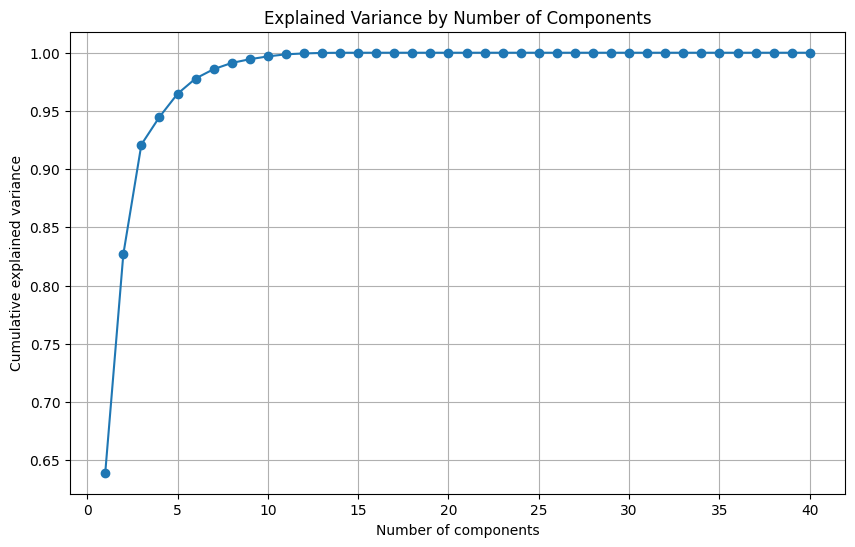

In [ ]:
# Plot the explained variance by number of components
explained_variances = []
n_components = list(range(1, 41))  # Adjust according to the dataset

for n in n_components:
    svd = TruncatedSVD(n_components=n)
    svd.fit_transform(patterns_matrix)
    explained_variances.append(svd.explained_variance_ratio_.sum())

plt.figure(figsize=(10, 6))
plt.plot(n_components, explained_variances, 'o-')
plt.title('Explained Variance by Number of Components')
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
plt.grid(True)
plt.show()

In [20]:
# Apply UMAP to the embeddings for dimentionality reduction and visualization
reducer = umap.UMAP(n_components=3, metric='cosine', random_state=42)
umap_embeddings = reducer.fit_transform(patterns_matrix)


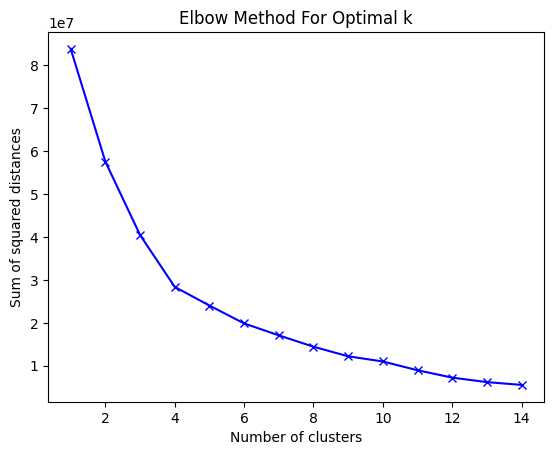

In [ ]:
# Calculate the sum of squared distances for different numbers of clusters
ssd = []
K = range(1, 15)  # Check for up to 15 clusters
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42,n_init=5)
    kmeans = kmeans.fit(umap_embeddings)
    ssd.append(kmeans.inertia_)

# Plot the SSDs for each number of clusters
plt.plot(K, ssd, 'bx-')
plt.xlabel('Number of clusters')
plt.ylabel('Sum of squared distances')
plt.title('Elbow Method For Optimal k')
plt.show()

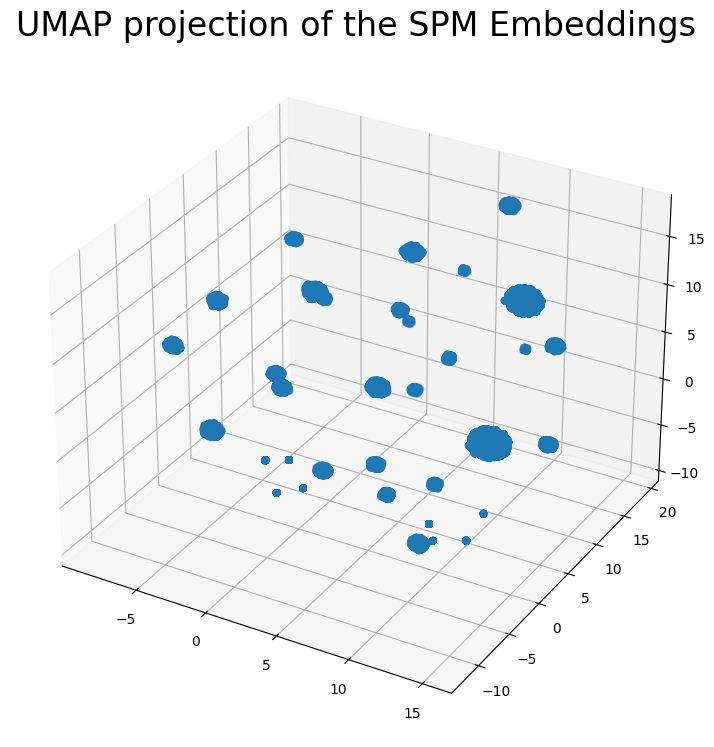

In [ ]:
# Plot the UMAP-transformed embeddings in 3D
fig = plt.figure(figsize=(10, 9))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(umap_embeddings[:, 0], umap_embeddings[:, 1], umap_embeddings[:, 2])
ax.set_title('UMAP projection of the SPM Embeddings', fontsize=24)
plt.show()

### Initial clustering using the pattern embeddings after applying UMAP dimentionality reduction

Cluster sizes:
0     82708
1     95142
2    143909
3    128739
4    104856
Name: cluster_1, dtype: int64

Mean session lengths:
cluster_1
0    32.422498
1    49.431933
2    31.244828
3    49.705365
4    31.558413
Name: session_length, dtype: float64

Average Time between Actions:
cluster_1
0    39.166069
1    23.378543
2    33.519864
3    24.314924
4    89.553801
Name: avg_time_between_actions, dtype: float64

Average Session Duration:
cluster_1
0     925.251777
1     940.962151
2     642.833033
3     849.990834
4    1123.807975
Name: session_duration, dtype: float64

Average Document Accesses per Cluster:
cluster_1
0    4.255791
1    4.788621
2    3.412302
3    2.901157
4    5.655404
Name: action, dtype: float64

Average Actions before New Document Access per Cluster:
cluster_1
0     7.776861
1    10.883912
2     8.262476
3    13.634622
4     5.737510
Name: action, dtype: float64

Average searches per Cluster:
cluster_1
0     0.071686
1    29.265782
2     3.963616
3    32.816512
4    

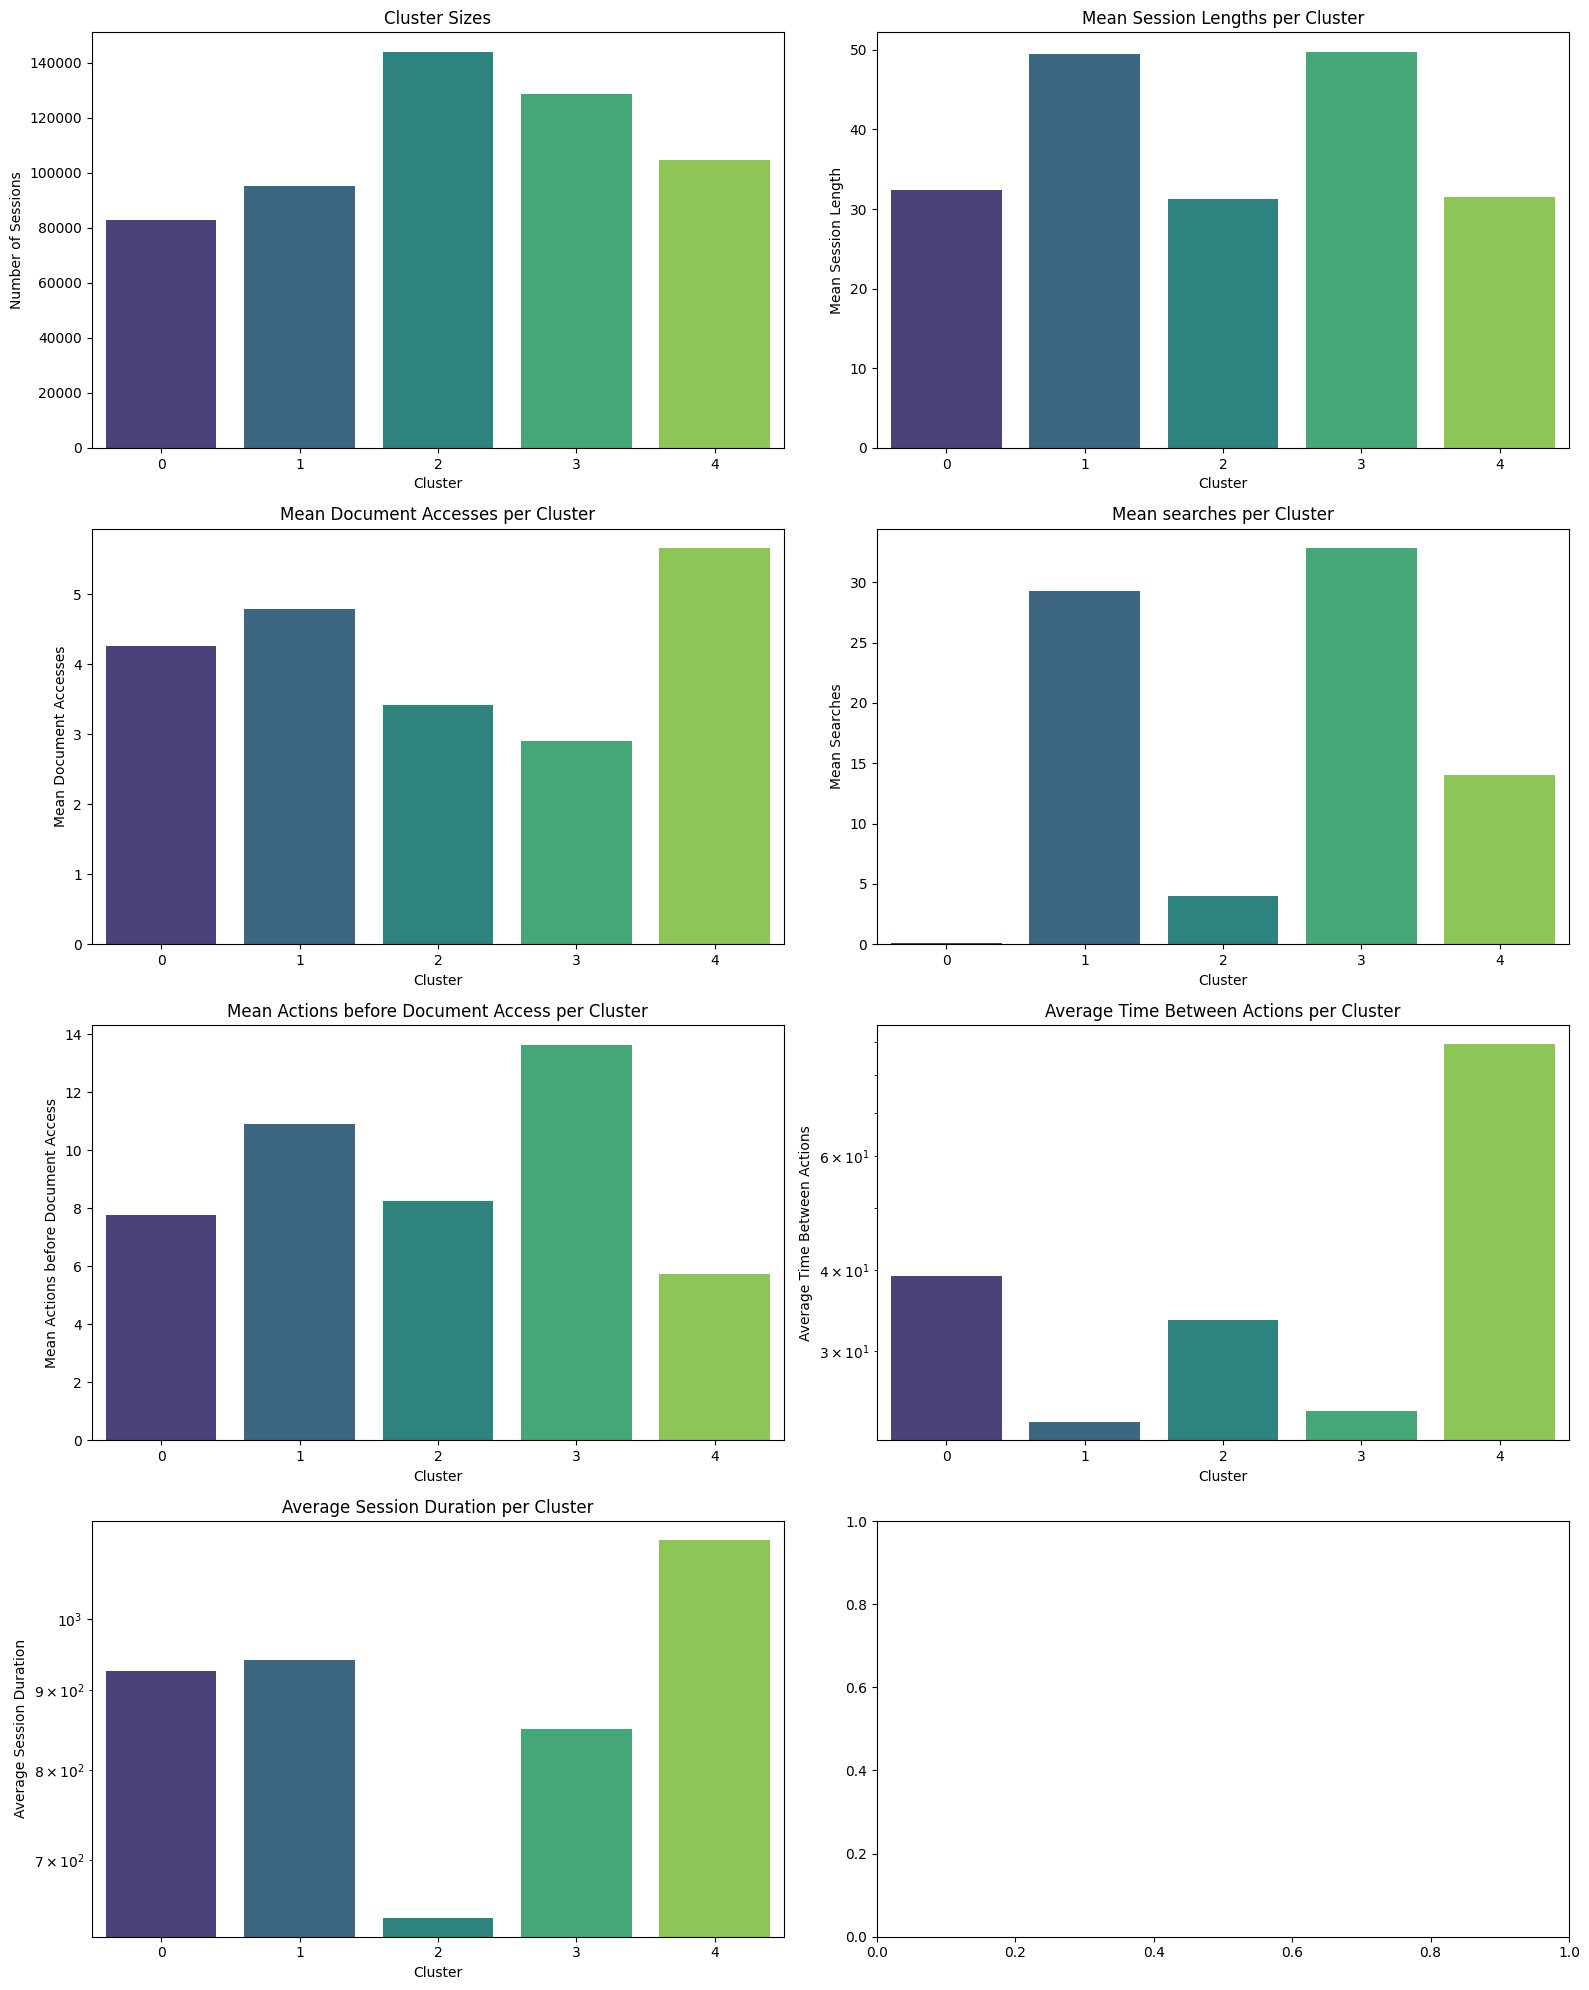

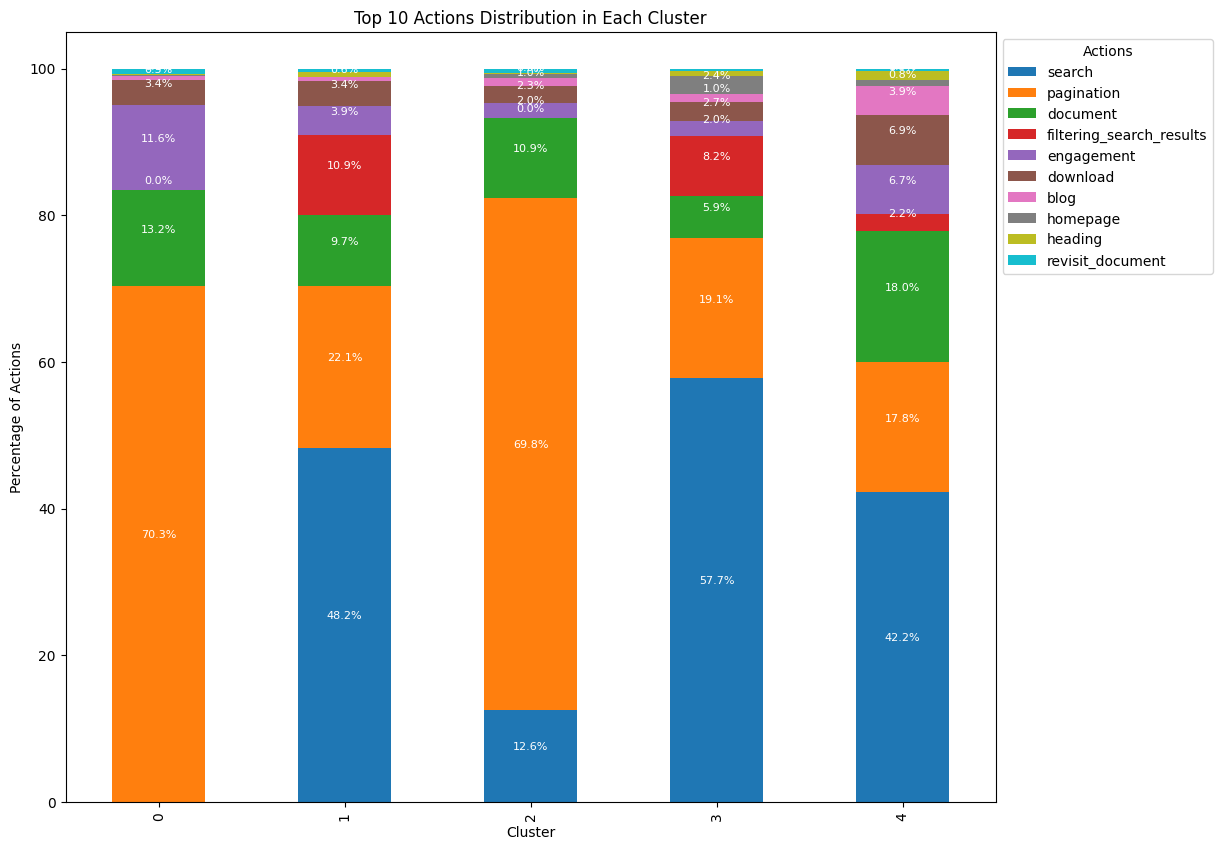

In [ ]:
# Choose the number of clusters
n_clusters = 5
# Initialize the KMeans object
kmeans = KMeans(n_clusters=n_clusters, random_state=42,n_init=5)

# Fit the KMeans object to the data and predict the cluster labels
sessions_grouped['cluster_1'] = kmeans.fit_predict(umap_embeddings)

directory = r'C:\Users\User\Desktop\Kraya\MA4\Semester_Project\graphs_clustering\SPM_100k_filtered'
if not os.path.exists(directory):
    # If not, create the directory
    os.makedirs(directory)
column = 'cluster_1'
actions_column = 'action'

visualize_clusters(directory, column, actions_column)

### Second clustering using the initial clustering + the features

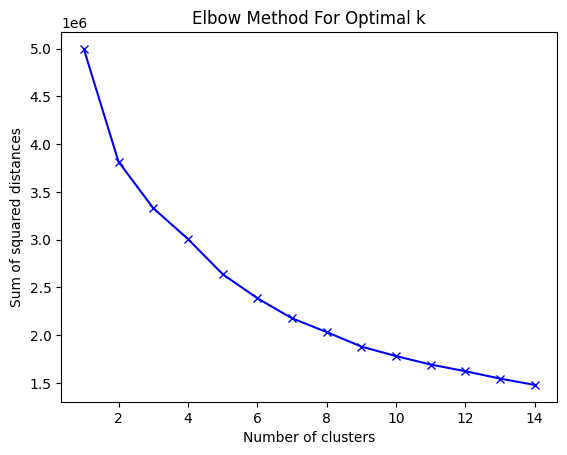

In [ ]:
# Select the features to be included in the second round of clustering
df_selected = sessions_grouped[['search_count', 'document_access_count', 'search_to_doc_access_ratio', 
                                'session_length', 'unique_actions', 'avg_actions_before_doc_access', 
                                'cluster_1','avg_time_between_actions', 'session_duration']]
df_selected = df_selected.replace([np.inf, -np.inf], np.nan)
df_selected = df_selected.fillna(0)

# Standardize the features
scaler = StandardScaler()
df_standardized = pd.DataFrame(scaler.fit_transform(df_selected), columns=df_selected.columns)
df_standardized['cluster_1'] = 5 * df_standardized['cluster_1']

# Calculate the sum of squared distances for different numbers of clusters
ssd = []
K = range(1, 15)  # Check for up to 15 clusters
for k in K:
    kmeans = KMeans(n_clusters=k,random_state=42,n_init=5)
    # Fit the model and predict the cluster labels
    cluster_labels = kmeans.fit_predict(df_standardized)
    ssd.append(kmeans.inertia_)
# Plot the SSDs for each number of clusters
plt.plot(K, ssd , 'bx-')
plt.xlabel('Number of clusters')
plt.ylabel('Sum of squared distances')
plt.title('Elbow Method For Optimal k')
plt.show()

Cluster sizes:
0    126965
1    241284
2     13893
3      7652
4     11806
5     38369
6     13225
7    102160
Name: cluster_spm, dtype: int64 0    22.861994
1    43.446883
2     2.501648
3     1.377860
4     2.125851
5     6.908927
6     2.381364
7    18.395474
Name: cluster_spm, dtype: float64

Mean session lengths:
cluster_spm
0     17.089355
1     22.432246
2    104.557475
3    128.280188
4     12.593088
5    131.526936
6     79.919622
7     52.080031
Name: session_length, dtype: float64

Average Time between Actions:
cluster_spm
0     35.752077
1     29.372677
2     14.143219
3     25.668813
4    636.020641
5     19.628619
6     11.493213
7     23.244461
Name: avg_time_between_actions, dtype: float64

Average Session Duration:
cluster_spm
0     392.242831
1     498.156202
2    1376.635716
3    2770.870361
4    5263.354311
5    2453.254893
6     874.826087
7    1053.846691
Name: session_duration, dtype: float64

Average Document Accesses per Cluster:
cluster_spm
0     2.320301
1   

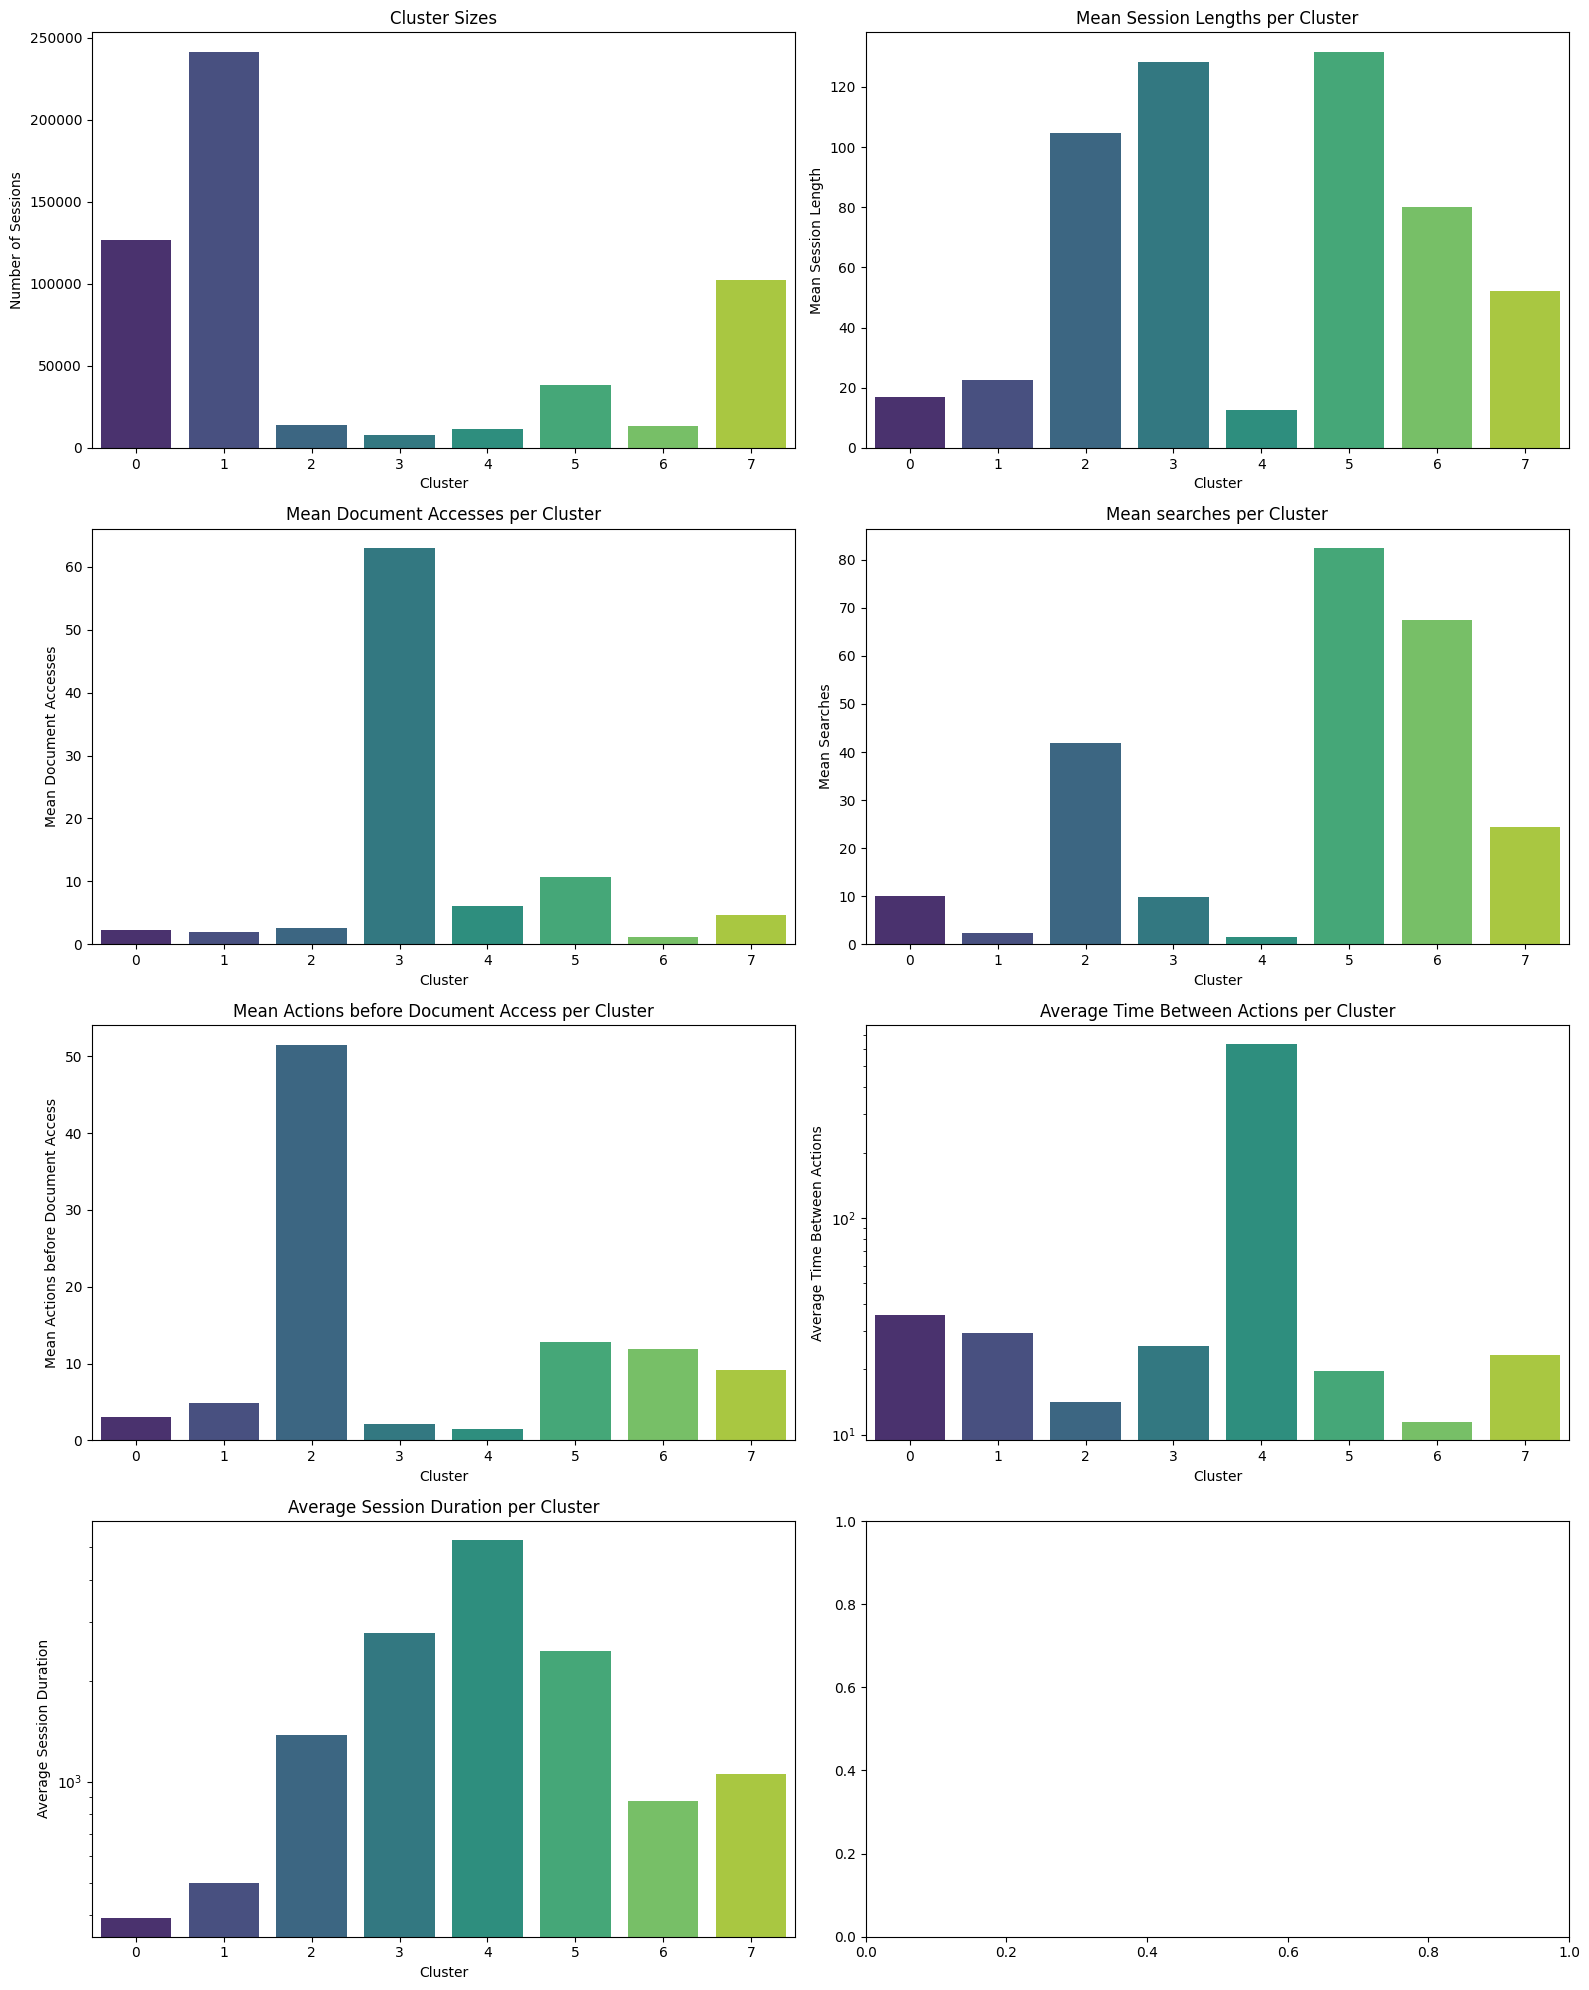

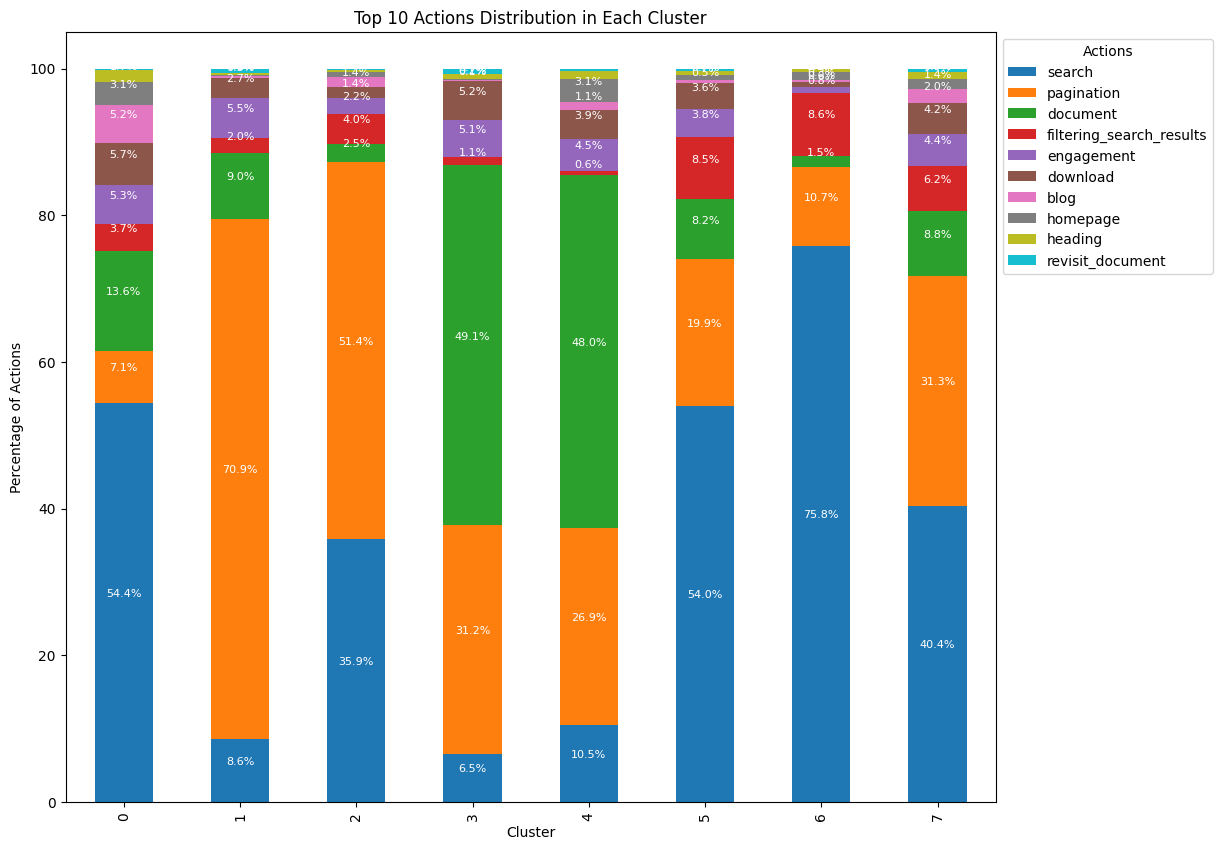

In [ ]:
# Choose the number of clusters
n_clusters = 8

# Initialize the KMeans object
kmeans = KMeans(n_clusters=n_clusters, random_state=42,n_init=5)

# Fit the KMeans object to the data and predict the cluster labels
sessions_grouped['cluster_spm'] = kmeans.fit_predict(df_standardized)
column = 'cluster_spm'
directory = r'C:\Users\User\Desktop\Kraya\MA4\Semester_Project\graphs_clustering\final'+'cluster_spm_100k'
if not os.path.exists(directory):
    # If not, create the directory
    os.makedirs(directory)

actions_column = 'action'

visualize_clusters(directory, column, actions_column)

In [83]:
action_dict = {v: k for k, v in action_to_int.items()}

In [ ]:
# Find the 3 closest sequences to the centroids for each cluster
closest_sequences = {}
# Function to compute the Euclidean distance
def euclidean_distance(a, b):
    return np.linalg.norm(a - b)
original_space_centroids = kmeans.cluster_centers_

for i in range(n_clusters):
    cluster_points = df_selected[sessions_grouped['cluster_spm'] == i]

    # Calculate distances between the centroid and the sequences
    distances = cluster_points.apply(lambda x: euclidean_distance(x, original_space_centroids[i]), axis=1)
    # Get the 3 closest sequences
    closest_sequences[i] = distances.nsmallest(10)

    # Print the sequences and session_ids for the current cluster
    print(f"Cluster {i}:")
    for j in closest_sequences[i].index:
        actions = sessions_grouped.loc[j]['action']
        session_id = sessions_grouped.loc[j]['session_id']
        encoded_actions= sessions_grouped.loc[j]['Encoded_Sequence']
        formatted_actions = []
        for k, action in enumerate(actions):
            if k == 0:
                formatted_actions.append(action)
                count = 1
            elif action == actions[k-1]:
                count += 1
            else:
                formatted_actions.append(f"{actions[k-1]} x{count}")
                count = 1
        formatted_actions.append(f"{actions[-1]} x{count}")
        formatted_actions_str = ' -> '.join(formatted_actions)
        distance = distances.loc[j]
        print(f"{formatted_actions_str} (Distance: {distance:.4f}) - Session ID: {session_id}")
    print()


Cluster 0:
